# Exercise 26 - SINDy for Structural Dynamics

### Task
Adapt the model parameters and the right-hand side of the system of differential equations

### Learning goals
- Understand how to apply SINDy to systems of ordinary differential equations (from structural dynamics)
- Experiment with SINDy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from scipy.integrate import solve_ivp

## Sequential thresholded least squares algorithm

**solves sparse regression**
$$\dot{\boldsymbol{X}}=\boldsymbol{\Theta}(\boldsymbol{X})\boldsymbol{\Xi}$$

In [ ]:
def sequentialThresholdedLeastSquares(theta, dXdt, k=10, tol=1e-1):
    Xi = np.linalg.lstsq(theta, dXdt, rcond=None)[0]
    for i in range(k):
        smallindices = abs(Xi) < tol
        Xi[smallindices] = 0
        for j in range(len(dXdt[1])):
            bigindices = ~smallindices[:, j]
            Xi[bigindices, j] = np.linalg.lstsq(theta[:, bigindices], dXdt[:, j], rcond=None)[0]
    return Xi

## SINDy class

In [ ]:
class SINDy:
    """A class used for sparse system identification of nonlinear dynamical systems
       Implementation adapted from https://arxiv.org/pdf/1509.03580.pdf"""

    def __init__(self, X, dXdt, theta):
        self.Xi = None
        self.X = X
        self.dXdt = dXdt
        self.theta = theta

    def solveSINDy(self, k=10, tol=1e-1):
        self.Xi = sequentialThresholdedLeastSquares(self.theta(np.transpose(self.X)), self.dXdt, k, tol)
        return self.Xi

    def solveODEs(self, interval, initialValues):
        if self.Xi is not None:
            def rhs(t, y):
                return np.dot(self.theta(y), self.Xi)

            solution = solve_ivp(rhs, interval, initialValues, method='LSODA', rtol=1e-6, min_step=1e-3, max_step=1e-3)
            return solution.t, solution.y
        else:
            return 1, 1

## Pre-processing

**SINDy hyperparameters (for sequential thresholded least squares)**

In [ ]:
tol = 1e-2
k = 10

**multi-dof system parameters** (adapt)

In [ ]:
k1 = lambda x: x
k2 = lambda x: 2 * x ** 3
m1 = 5
m2 = 2
d1 = lambda x: x
d2 = lambda x: 1

## Data generation 

**definition of the right hand sides** (adapt)

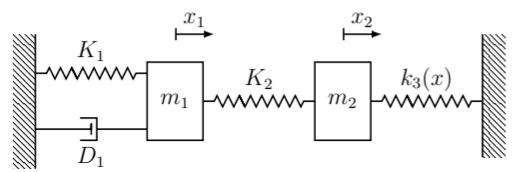

In [ ]:
def rhs(t, y):
    return [y[1],
            -(k1(y[0]) + d1(y[1]) + k2(y[0] - y[2]) + d2(y[1] - y[3])) / m1,
            y[3],
            -(k2(y[2] - y[0]) + d2(y[3] - y[1])) / m2]

**solve system of ordinary differential equations**

In [ ]:
solution = solve_ivp(rhs, (0, 50), [1, 0, 0, 0], method='LSODA', rtol=1e-6, min_step=1e-3, max_step=1e-3)

**sampling parameters for snapshot matrix**

In [ ]:
everyn = 20
cap = 400

**snapshot matrix**

In [ ]:
t = np.expand_dims(solution.t[::everyn], axis=1)

X = np.transpose(solution.y[:, ::everyn])
dXdt = (X[1:] - X[:-1]) / ((t[1:] - t[:-1]))  #forward difference
t = t[:-1]
X = X[:-1]

t = t[:cap]
X = X[:cap]
dXdt = dXdt[:cap]

**library of candidate functions**

In [ ]:
theta = lambda X: np.transpose(np.array([X[0] * 0 + 1,
                                         X[0], X[1], X[2], X[3],
                                         X[0] ** 2, X[2] ** 2, X[0] * X[2],
                                         X[0] ** 3, X[2] ** 3,
                                         X[0] ** 2 * X[2], X[0] * X[2] ** 2]))

## SINDy

In [ ]:
model = SINDy(X, dXdt, theta)
Xi = model.solveSINDy(k, tol)
print(Xi)

## Post-processing

**post-processing helper (plots trajectory based on identified system)**

In [ ]:
def plotEstimate(tSample, XSample, tEstimate, XEstimate):
    color = ['b', 'r', 'gray', 'silver']

    # Set up plot
    fig, ax = plt.subplots()

    # Plot data
    for i in range(len(XSample[0])):
        plt.plot(tSample, XSample[:, i], 'o', color=color[i])
        plt.plot(tEstimate, XEstimate[i], '-', color=color[i], label='$y_{}$'.format(i + 1))

    l1 = plt.Line2D([0], [0], marker='o', lw=0, color='k', label='sample', markersize=12)
    l2 = plt.Line2D([0], [0], color='k', label='prediction')
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.extend([l1, l2])

    ax.set_xlabel("$t$")
    ax.set_ylabel("$y$")
    ax.legend()
    fig.tight_layout()
    plt.show()

**predict trajectories by solving system of ordinary differential equations**

In [ ]:
tEstimate, XEstimate = model.solveODEs((0, 20), [X[0, 0], X[0, 1], X[0, 2], X[0, 3]])

**predicted trajectories**

In [ ]:
plotEstimate(t, X, tEstimate, XEstimate)